<a href="https://colab.research.google.com/github/ziatdinovmax/ML-ElectronMicroscopy-2023/blob/main/Lecture%2024/rVAE_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rotationally-Invariant Variational Autoencoders from Scratch

*Notebook prepared by Maxim Ziatdinov (2023)*

This notebook provides a hands-on guide to implementing rotationally-invariant Variational Autoencoders (VAEs) in PyTorch. VAEs are a powerful generative model known for their ability to learn rich latent representations of data. Here we extend VAE to disentangle arbitrary rotations in 2D image data.

The core idea of a standard VAE is that complex real-world observations can be explained by a limited number of disentangled latent variables. These variables capture the primary factors of variation. A VAE is made up of a decoder, which reconstructs observations from a latent code, and an encoder that approximates the true posterior probability using amortized variational inference.

However, Locatello *et al.* have [shown](https://arxiv.org/abs/1811.12359v4) that unsupervised learning of disentangled latent representations is impossible without specific inductive biases. These biases often involve changes to the loss function or modifications to the encoder and decoder network architectures.

For VAE applications in domain sciences, we believe that the necessary inductive biases can be derived from existing domain knowledge. This includes understanding measurement factors and information from theory about key length scales and system symmetries.

The notebook illustrates this concept using the r-VAE technique, which is employed to analyze 2D image data in the presence of arbitrary rotations.


In [1]:
!pip install -q kornia # for fast image transformations

Make neccessary imports:

In [2]:
from typing import Tuple, Optional, Type

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets

import kornia as K

import math

import matplotlib.pyplot as plt

Define helper functions for generating arbitrary rotated images:

In [3]:
def rotate_images(imgdata, rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    torch.manual_seed(0)
    theta = torch.randint(*rotation_range, size=(len(imgdata),))
    imgdata = K.geometry.rotate(imgdata.float()[:, None], theta.float())
    imgdata = imgdata / imgdata.max()
    return imgdata, theta


def get_mnist_data(rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    !wget -qq www.di.ens.fr/~lelarge/MNIST.tar.gz
    !tar -zxf MNIST.tar.gz
    mnist_trainset = datasets.MNIST(
        root='.', train=True, download=False, transform=None)
    images_r, theta = rotate_images(mnist_trainset.data, rotation_range)
    images_r = images_r.flatten(1)
    images_r = images_r / images_r.max()
    return images_r, mnist_trainset.train_labels, theta

Get training data:

In [ ]:
train_data, train_labels, angles = get_mnist_data(rotation_range=[-60, 61])

Visualize some training samples:

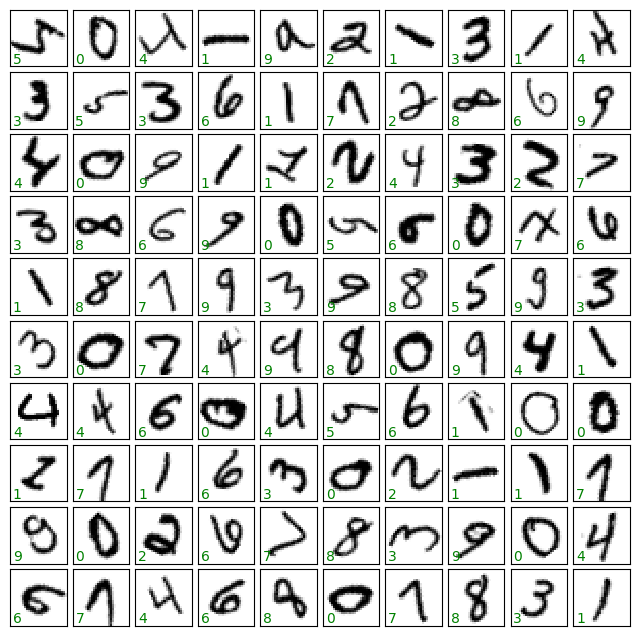

In [5]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im.reshape(28, 28), cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.item()),
            transform=ax.transAxes, color='green')

In r-VAE, we designate one of the latent variables to capture the information about the orientation, whereas the rest of the latent variables “look” for other (than orientation) factors of variation. Let’s call this special latent variable a “latent angle variable”. We start by creating a 2D coordinate grid whose size is (height*width, 2). Our encoder maps the inputs (images) into the latent angle variable and two (or more) conventional latent variables. Assuming that srotations are normally distributed, the latent angle vector is sampled from a unit Gaussian distribution. The sampled values are used to rotate our coordinate grid, which is then concatenated with the conventional latent variables and passed to the VAE’s decoder to enforce a geometric consistency between the rotated images.

The concatenation of spatial coordinates and ltent vector requires changes in the decoder architecture. Here we will utilize the spatial decoder architecture introduced by [Bepler *et al*](https://arxiv.org/abs/1909.11663). Our encoder remains almost the same - the only difference is that we added one "extra" latent dimension assocaited with a "latent angle."

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(Encoder, self).__init__()

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())

        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())

        self.hidden_layers = nn.Sequential(*layers)

        # Mean and log variance layers
        self.fc_mean = nn.Linear(hidden_dims[-1], latent_dim + 1)  # +1 to account for rotation
        self.fc_logstd = nn.Linear(hidden_dims[-1], latent_dim + 1)

    def forward(self, x):
        h = self.hidden_layers(x)
        mean = self.fc_mean(h)
        logstd = self.fc_logstd(h)
        return mean, logstd


class coord_latent(nn.Module):
    """
    Concatenate (transformed) spatial coordinates with latent vector
    (based on https://arxiv.org/abs/1909.11663)
    """
    def __init__(self,
                 latent_dim: int,
                 out_dim: int,
                 ndim: int = 2) -> None:
        """
        Initializes module
        """
        super(coord_latent, self).__init__()
        self.fc_coord = nn.Linear(ndim, out_dim)
        self.fc_latent = nn.Linear(latent_dim, out_dim, bias=False)
        self.activation = nn.ReLU()

    def forward(self,
                x_coord: torch.Tensor,
                z: torch.Tensor) -> torch.Tensor:
        """
        Forward pass
        """
        batch_dim, n = x_coord.size()[:2]
        x_coord = x_coord.reshape(batch_dim * n, -1)
        h_x = self.fc_coord(x_coord)
        h_x = h_x.reshape(batch_dim, n, -1)
        h_z = self.fc_latent(z)

        h_z = h_z.view(-1, h_z.size(-1))
        h = h_x.add(h_z.unsqueeze(1))
        h = h.reshape(batch_dim * n, -1)
        h = self.activation(h)
        return h


class sDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims, output_dim):
        super(sDecoder, self).__init__()

        layers = []
        layers.append(nn.ReLU())

        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())

        self.coord_latent = coord_latent(latent_dim, hidden_dims[0], 2)  # 2 for image ndim
        self.hidden_layers = nn.Sequential(*layers)

        # Output layer
        self.fc_out = nn.Linear(hidden_dims[-1], 1)
        self.output_dim = output_dim

    def forward(self, z, x_coord):
        z = self.coord_latent(x_coord, z)
        h = self.hidden_layers(z)
        reconstruction = torch.sigmoid(self.fc_out(h))
        reconstruction = reconstruction.view(-1, self.output_dim) # Unflatten
        return reconstruction

Let's define helper functions for generating and rotating a grid of spatial coordinates. Alternatively, we can do this inside the rVAE class, but it will be too messy.

In [7]:
def rotate_coordinates(coord: torch.Tensor,
                       phi: torch.Tensor,
                       ) -> torch.Tensor:
    """
    Rotation of 2D coordinates. Operates on batches
    """
    rotmat_r1 = torch.stack([torch.cos(phi), torch.sin(phi)], 1)
    rotmat_r2 = torch.stack([-torch.sin(phi), torch.cos(phi)], 1)
    rotmat = torch.stack([rotmat_r1, rotmat_r2], axis=1)
    coord = torch.bmm(coord, rotmat)
    return coord


def grid2xy(X1: torch.Tensor, X2: torch.Tensor) -> torch.Tensor:
    X = torch.cat((X1[None], X2[None]), 0)
    d0, d1 = X.shape[0], X.shape[1] * X.shape[2]
    X = X.reshape(d0, d1).T
    return X


def imcoordgrid(im_dim: Tuple[int]) -> torch.Tensor:
    xx = torch.linspace(-1, 1, im_dim[0])
    yy = torch.linspace(1, -1, im_dim[1])
    x0, x1 = torch.meshgrid(xx, yy)
    return grid2xy(x0, x1)

Now let's construct the r-VAE class. Compared to the standard VAE, the forward method now includes spatial transformations within the latent space. Unlike the standard VAE which only encodes and decodes the data, this version additionally breaks down the latent vector into components associated with spatial rotation (```phi_vec```) and data content (```z_vec```). It then uses the rotation component to transform the original pixel coordinates, adjusting their spatial layout before decoding. This effectively allows the model to learn spatial variations in the input data alongside its inherent content.

In [8]:
class rVAE(nn.Module):

    def __init__(self, encoder, decoder, img_dim):
        super(rVAE, self).__init__()

        device = "cuda" if torch.cuda.is_available() else 'cpu'

        self.encoder = encoder
        self.decoder = decoder

        self.grid = imcoordgrid(img_dim).to(device)

        self.to(device)
        self.device = device


    def compute_kld(self,
                     z: torch.Tensor,
                     q_param: Tuple[torch.Tensor],
                     p_param: Optional[Tuple[torch.Tensor]] = None
                     ) -> torch.Tensor:
        """
        Computes KL divergence term between two normal distributions
        or (if p_param = None) between normal and standard normal distributions
        """
        qz = self._log_normal(z, *q_param)
        if p_param is None:
            pz = self._log_unit_normal(z)
        else:
            pz = self._log_normal(z, *p_param)
        return qz - pz

    def compute_likelihood(self,
                           x: torch.Tensor,
                           x_reconstr: torch.Tensor
                           ) -> torch.Tensor:
        """
        Computes how well the model's reconstructions explain the data
        (which is effectively negative negative reconstruction loss)
        """
        reconstr_loss = F.binary_cross_entropy(
            x_reconstr.flatten(1), x.flatten(1), reduction='none').sum(-1)

        return -reconstr_loss

    @classmethod
    def _reparameterize(cls,
                        z_mu: torch.Tensor,
                        z_logsig: torch.Tensor
                        ) -> torch.Tensor:
        """Reparametrization trick"""
        batch_dim = z_mu.size(0)
        z_dim = z_mu.size(1)
        z_sig = torch.exp(z_logsig)
        eps = z_mu.new(batch_dim, z_dim).normal_()
        return z_mu + z_sig * eps

    @classmethod
    def _log_normal(cls,
                   x: torch.Tensor,
                   mu: torch.Tensor,
                   log_sig: torch.Tensor
                   ) -> torch.Tensor:
        """
        Computes log-pdf of a normal distribution
        """
        log_pdf = (-0.5 * math.log(2 * math.pi) - log_sig -
                   (x - mu)**2 / (2 * torch.exp(log_sig)**2))
        return torch.sum(log_pdf, dim=-1)

    @classmethod
    def _log_unit_normal(cls, x: torch.Tensor) -> torch.Tensor:
        """
        Computes log-pdf of a unit normal distribution
        """
        log_pdf = -0.5 * (math.log(2 * math.pi) + x ** 2)
        return torch.sum(log_pdf, dim=-1)


    def forward(self, x: torch.Tensor):
        """Forward pass"""

        self.kl_divergence = 0
        self.likelihood = 0
        # Encode data
        z_mu, z_logsig = self.encoder(x)
        # Obtain latent vector throught the 'reparametrization trick'
        z_vec = self._reparameterize(z_mu, z_logsig)
        # Compute KLD assuming same prior distributions for the latent angle and standard latent variables
        self.kl_divergence += self.compute_kld(z_vec, (z_mu, z_logsig))
        # Split latent vector into parts associated with rotation and data content
        phi_vec = z_vec[:, 0]
        z_vec = z_vec[:, 1:]
        # Expand spatial coordinates to match the batch size of the encoded representation
        x_coord = self.grid.expand(phi_vec.size(0), *self.grid.size())
        # Transform the original pixel coordinates with the encoded angle variable
        x_coord = rotate_coordinates(x_coord, phi_vec)
        # Pass the transformed coordinates and standard latent vectors to the decoder
        x_reconstr = self.decoder(z_vec, x_coord)
        # Compute likelihood (negative reconstruction loss)
        self.likelihood += self.compute_likelihood(x, x_reconstr)

        return x_reconstr

Let's proceed and initialize our rVAE with encoder and (spatial) decoder neural nets and set up a standard PyTorch optimizer to adjust the parameters of the rVAE during training:

In [9]:
encoder = Encoder(784, [512, 256, 128], 2)
decoder = sDecoder(2, [128, 256, 512], 784)

rvae_model = rVAE(encoder, decoder, (28, 28))
optimizer = torch.optim.Adam(rvae_model.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Next we initialize the data loading mechanism for the model training using built-in PyTorch utilities:

In [10]:
def init_dataloader(*args: torch.Tensor,
                    batch_size: int = 100,
                    shuffle: bool = True,
                    ) -> Type[torch.utils.data.DataLoader]:
    """
    Returns initialized PyTorch dataloader
    """
    tensor_set = torch.utils.data.dataset.TensorDataset(*args)
    data_loader = torch.utils.data.DataLoader(
            dataset=tensor_set, batch_size=batch_size, shuffle=shuffle)
    return data_loader

# Initialize train loader
train_loader = init_dataloader(train_data, batch_size=100)

Finally we are ready to train our model. Let's define a single training step:

In [11]:
def train_step(x: torch.Tensor, beta: int = 1) -> torch.Tensor:
    """Conducts a single training step for a (r)VAE model"""
    # Set the model to training mode
    rvae_model.train()
    # Perform a forward pass with input tensor x
    _ = rvae_model(x.to(rvae_model.device))
    # Compute the loss: negative likelihood + beta * KL divergence. Then, take the mean over the batch.
    loss = (-rvae_model.likelihood + beta * rvae_model.kl_divergence).mean()
    # Perform backpropagation to compute gradient of loss w.r.t. model parameters.
    loss.backward()
    # Update the model parameters using the computed gradients.
    optimizer.step()
    # Reset gradients to zero for the next iteration.
    optimizer.zero_grad()
    # Return the loss value as a Python scalar.
    return loss.item()

Train the rVAE model:

In [12]:
epochs = 100

train_loss = []
for e in range(epochs):
    train_loss_i = 0
    for (x,) in train_loader:
        loss_i= train_step(x)
        train_loss_i += loss_i

    train_loss.append(train_loss_i / len(train_loader))
    print("Epoch {},  Train loss {}".format(e+1, train_loss[-1]))

Epoch 1,  Train loss 246.2346685028076
Epoch 2,  Train loss 191.26134302775066
Epoch 3,  Train loss 180.16834396362304
Epoch 4,  Train loss 173.35240272521972
Epoch 5,  Train loss 168.83033170064292
Epoch 6,  Train loss 165.7068121592204
Epoch 7,  Train loss 163.335440826416
Epoch 8,  Train loss 161.61149164835612
Epoch 9,  Train loss 160.132601852417
Epoch 10,  Train loss 158.98223897298178
Epoch 11,  Train loss 158.06265485127767
Epoch 12,  Train loss 157.22137219746907
Epoch 13,  Train loss 156.4993507639567
Epoch 14,  Train loss 155.83365994771322
Epoch 15,  Train loss 155.27597999572754
Epoch 16,  Train loss 154.72924293518065
Epoch 17,  Train loss 154.253834177653
Epoch 18,  Train loss 153.80835645039878
Epoch 19,  Train loss 153.3657662963867
Epoch 20,  Train loss 152.949898630778
Epoch 21,  Train loss 152.64741317749022
Epoch 22,  Train loss 152.2699449666341
Epoch 23,  Train loss 151.96882624308267
Epoch 24,  Train loss 151.62042170206706
Epoch 25,  Train loss 151.393764801025

Text(0, 0.5, 'Loss')

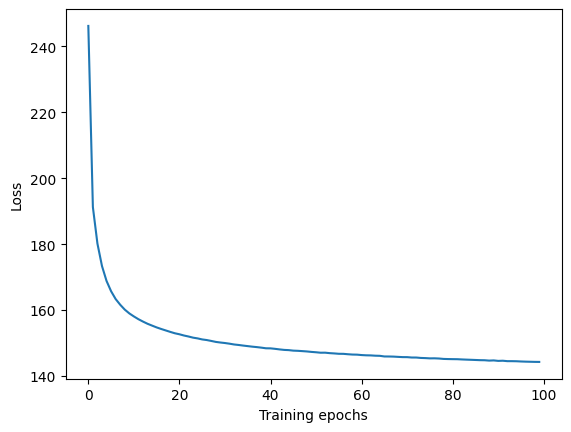

In [13]:
plt.plot(train_loss)
plt.xlabel("Training epochs")
plt.ylabel("Loss")

Having trained our rVAE model, our next task is to inspect its performance, especially how it encodes data into the latent space:



In [14]:
rvae_model.eval()
test_loader = init_dataloader(train_data, shuffle=False) # set shuffle to False so that we can compare to the ground truth labels
with torch.no_grad():
    z = torch.cat([rvae_model.encoder(x.to(rvae_model.device))[0].cpu() for (x,) in test_loader])

Plot the encoded latent represenation associated with data content:

Text(0, 0.5, '$z_2$')

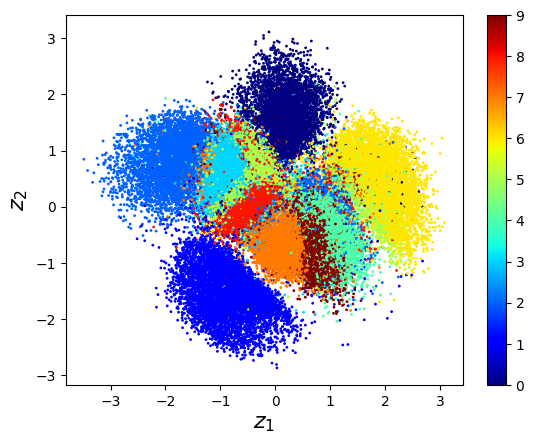

In [15]:
plt.scatter(z[:, -2], z[:, -1], s=1, c=train_labels, cmap='jet')
plt.colorbar()
plt.xlabel("$z_1$", fontsize=16)
plt.ylabel("$z_2$", fontsize=16)

We also get the angle as one of the latent variables, and the latent angle and ground truth angle are compared in the figure below. Note that they are linearly related, but at the same time latent angles have broad distribution. This is unsurprising since an angle is one of the characteristics of handwriting style and varies from person to person!

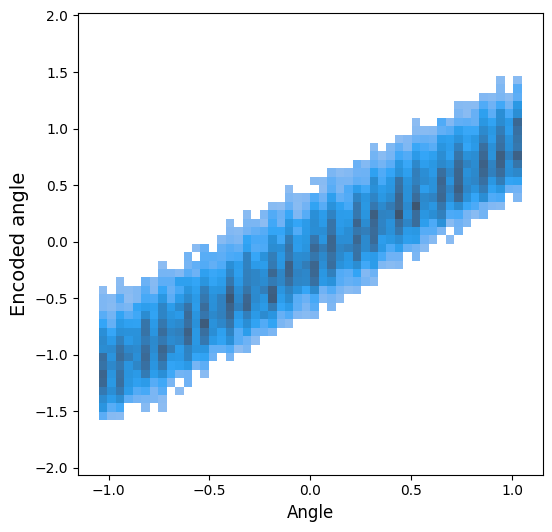

In [16]:
import seaborn as sns

plt.figure(figsize=(6, 6))
plt.xlabel("Angle", fontsize=12)
plt.ylabel("Encoded angle", fontsize=14)
ax = sns.histplot(x=torch.deg2rad(angles.float()), y=z[:, 0], bins=50, pthresh=.1);

To see how our rVAE model captures the intrinsic structure of the data alongside arbitrary rotations, we will explore its ability to generate new samples as we traverse its latent space.

In [18]:
def generate_latent_grid(d=10):
    """
    Generates a grid of latent space coordinates
    """
    dist = torch.distributions
    if isinstance(d, int):
        d = [d, d]
    grid_x = dist.Normal(0, 1).icdf(torch.linspace(0.95, 0.05, d[0]))
    grid_y = dist.Normal(0, 1).icdf(torch.linspace(0.05, 0.95, d[1]))
    z = []
    for xi in grid_x:
        for yi in grid_y:
            z.append(torch.tensor([xi, yi]).float().unsqueeze(0))
    return torch.cat(z), (grid_x, grid_y)

d = 20
z_grid, (gridx, gridy) = generate_latent_grid(d)

# Expand the coordinate grid to match the number of samples in the z_grid.
coord_grid = rvae_model.grid.expand(len(z_grid), *rvae_model.grid.shape)

with torch.no_grad():  # the coordinate grid is passed alongside the z grid
    manifold = rvae_model.decoder(z_grid.to(rvae_model.device), coord_grid.to(rvae_model.device)).cpu()

# reshapes the decoded samples into images of size 28x28 allowing for straightforward visualization with torchvision
manifold = manifold.reshape(int(d*d), 1, 28, 28)

Visualize results:

([], [])

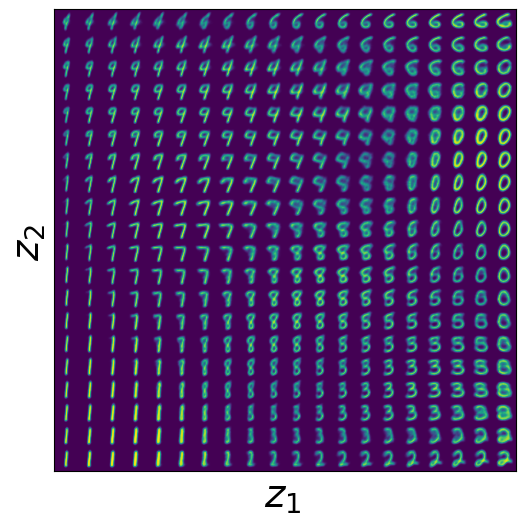

In [19]:
grid = torchvision.utils.make_grid(manifold, nrow=d, padding=2, pad_value=0)[0]
plt.figure(figsize=(6,6))
plt.imshow(grid, cmap='viridis')
plt.xlabel("$z_1$ ", fontsize=28)
plt.ylabel("$z_2$ ", fontsize=28)
plt.xticks([])
plt.yticks([])